In [3]:
import pandas as pd
import numpy as np
from collections import namedtuple
import matplotlib.pyplot as plt
%matplotlib inline

## Indlæs bidragssatser

In [4]:
tables = pd.read_html('https://www.mybanker.dk/sammenlign/bolig/bidragssatser/', decimal=',', skiprows=2, index_col=0)

table_names = ('BRF', 'Total', 'Nordea', 'RD')
table_headers = (('Fast', 'Flex', 'F-kort'), 
                 ('Fast', 'F3 - F4', 'F5 - F10', 'F-kort'),
                 ('Fast', 'F1', 'F3', 'F5 - F-kort'),
                 ('Fast', 'F1 - F2', 'F3 - F4', 'F5 - F10'))

In [5]:
def format_table(table_no):
    df = pd.merge(tables[table_no*2 + 1], tables[table_no*2 + 2], how='outer', left_index=True, right_index=True)
    df.columns = pd.MultiIndex.from_product((table_headers[table_no], (True, False)), names=['låntype', 'afdrag'])
    df.index.name = 'belåning'
    df = pd.melt(df.reset_index(), id_vars=['belåning'], value_name='rente')
    df['bank'] = table_names[table_no]
    df['rente'] = pd.to_numeric(df['rente'].str.replace(',', '.').str.rstrip('.%'))
    return df

In [6]:
bidrag_df = pd.concat((format_table(i) for i in range(4))).reset_index(drop=True)
bidrag_df.loc[(bidrag_df['bank'] == 'RD') & (bidrag_df['låntype'] == 'Fast') & (bidrag_df['afdrag'] == False), 'rente'] += .1
bidrag_df.head()

,belåning,låntype,afdrag,rente,bank
0,0-40 %,Fast,True,0.325,BRF
1,40-60 %,Fast,True,0.800,BRF
2,60-80 %,Fast,True,1.000,BRF
3,0-40 %,Fast,False,0.400,BRF
4,40-60 %,Fast,False,1.000,BRF


## Indlæs kurser

In [7]:
kurser = dict()

Realkredit Danmark

In [8]:
rd_url = 'https://www.rd.dk/da-dk/erhverv/Finansiering/Kurser-og-renter/Pages/aktuelle-kurser.aspx?valutakode=DKK'
df = pd.read_html(rd_url)
kurser.update(dict(RD=dict(uafdrag=float(df[3].iloc[4, 3])/100, afdrag=float(df[4].iloc[1, 3])/100)))

In [9]:
kurser

{'RD': {'afdrag': 97.46, 'uafdrag': 98.88}}

## Opret klasser til håndtering af låneberegninger

In [10]:
def udregn_terminsydelse(hovedstol, rente, løbetid):
    rente_måned = rente / 100. / 12.
    return hovedstol * rente_måned / (1 - np.power(1 + rente_måned, -løbetid * 12))

In [11]:
class Bidrag:
    def __init__(self, bank, låntype, vurdering):
        self.vurdering = vurdering
        self.satser = bidrag_df[(bidrag_df['bank'] == bank) & (bidrag_df['låntype'] == låntype)].set_index('belåning')
        
    def beregn(self, gæld, afdrag=False):
        sats = self.satser[self.satser['afdrag'] == afdrag]
        belåning = gæld / self.vurdering
        
        bidragsbeløb =  (min(0.4 * self.vurdering, gæld) / 100) * sats.loc['0-40 %', 'rente']
        if belåning > 0.4:
            bidragsbeløb += ((gæld - 0.4 * self.vurdering) / 100) * sats.loc['40-60 %', 'rente']
        if belåning > 0.6:
            bidragsbeløb += ((gæld - 0.6 * self.vurdering) / 100) * sats.loc['60-80 %', 'rente']
        return bidragsbeløb, 100 * bidragsbeløb / hovedstol

In [12]:
TerminData = namedtuple('TerminData', 'rente afdrag bidrag ydelse efterskat gæld')
class Lån:
    def __init__(self, hovedstol, vurdering, løbetid, afdragsfrihed, rente, skatteprocent, bank, låntype):
        self.terminsydelse = udregn_terminsydelse(hovedstol, rente, løbetid - afdragsfrihed)
        self.bidrag = Bidrag(bank, låntype, vurdering)
        self._info = dict(bank=bank, låntype=låntype, rente=rente, afdragsfrihed=afdragsfrihed, hovedstol=hovedstol)
        self.gæld = hovedstol
        self.afdragsfrihed = afdragsfrihed * 12
        self.skatteprocent = skatteprocent / 100
        self.forløb = list()
        self.termin = 0
        self.beregn_forløb(rente, løbetid)
        
    def step(self, rente):
        termin_afdragsfrihed = self.termin < self.afdragsfrihed
        bidragsbeløb, bidragssats = self.bidrag.beregn(gæld=self.gæld, afdrag= not termin_afdragsfrihed)
        
        # Udregn individuelle bidrag
        termin_rente = (rente / 12) * self.gæld / 100
        termin_afdrag = self.terminsydelse - termin_rente if not termin_afdragsfrihed else 0
        termin_bidrag = bidragsbeløb / 12
        termin_ydelse = termin_rente + termin_bidrag + termin_afdrag
        termin_ydelse_skat = (termin_rente + termin_bidrag) * (1 - self.skatteprocent)
        
        self.gæld -= termin_afdrag
        self.termin += 1
        return TerminData._make((termin_rente, termin_afdrag, termin_bidrag, termin_ydelse, termin_ydelse_skat, self.gæld))
    
    def beregn_forløb(self, rente, løbetid):
        if len(self.forløb) == 0:
            for i in range(løbetid * 12):
                self.forløb.append(self.step(rente))
            self.forløb = pd.DataFrame.from_records(self.forløb, columns=TerminData._fields)
    
    def plot(self):
        self.forløb.plot(secondary_y='gæld', figsize=(14, 10));
        
    def head(self):
        return self.forløb.head()
    
    def info(self):
        return '{} {}% {} {} år'.format(self._info['bank'], self._info['rente'], self._info['låntype'], self._info['afdragsfrihed'])
    
    def omkostninger(self):
        return self.forløb[['rente', 'bidrag']].values.sum(), self.forløb['efterskat'].sum()
    
    def __repr__(self):
        return \
        """
        Udgifter:\t{:.2f} kr
        - Efter skat:\t{:.2f} kr
        """.format(*self.omkostninger())
        
    def __getitem__(self, i):
        return self.forløb[i]

## Test

In [82]:
vurdering = 6000000
hovedstol = 2400000
løbetid = 30  # år
afdragsfrihed = 0  # år
rente = 2
skatteprocent = 26

In [83]:
bidrag = Bidrag('RD', 'Fast', vurdering)
print('Bidragsbeløb: {}, bidragssats: {}'.format(*bidrag.beregn(hovedstol, afdrag=True)))

Bidragsbeløb: 6595.2, bidragssats: 0.2748


In [84]:
print('Ekstra omkostning ved afdragsfrihed pga. kurs: {:.2f} kr.'.format((kurser['RD']['uafdrag'] - kurser['RD']['afdrag']) * hovedstol / 100))

Ekstra omkostning ved afdragsfrihed pga. kurs: 34080.00 kr.


In [85]:
lån = Lån(hovedstol, vurdering, løbetid, afdragsfrihed=afdragsfrihed, rente=rente, skatteprocent=skatteprocent, bank='RD', låntype='Fast')
lån


        Udgifter:	902540.83 kr
        - Efter skat:	667880.21 kr
        

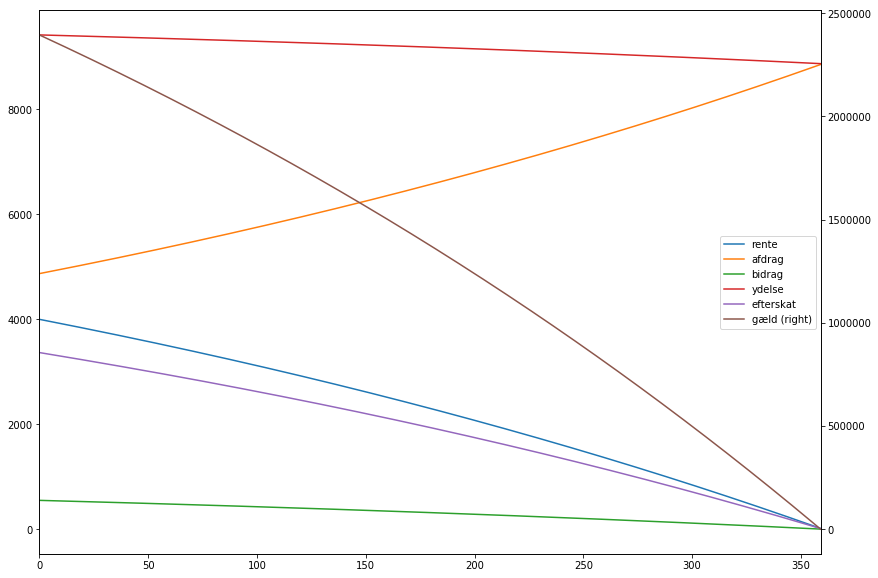

In [86]:
lån.plot()

## Sammenlign lån

In [44]:
def sammenlign_plot(inputs, cols=None):
    if not cols:
        cols = inputs[0].forløb.columns
    
    nrows = max(len(cols) // 2, 1)
    ncols = max(len(cols) // nrows, 1)
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(20, 2*len(cols)), sharex=True)
    
    if len(cols) > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
        
    for n, (ax, col) in enumerate(zip(axes, cols)):
        pd.DataFrame({i.info(): i[col] for i in inputs}).plot(ax=ax, title=f'{col}', legend=False)
        if n == ncols - 1:
            ax.legend(loc='upper center', bbox_to_anchor=(1.3, 1.05))
    
    print('Omkostninger efter skat: ')
    for i in inputs:
        print('{}:\t{:.2f} kr'.format(i.info(), i.omkostninger()[1]))
    print('')

Omkostninger efter skat: 
RD 2% Fast 0 år:	667880.21 kr
BRF 2% Fast 0 år:	682618.91 kr
Nordea 2% Fast 0 år:	697298.88 kr
Total 2% Fast 0 år:	719318.85 kr



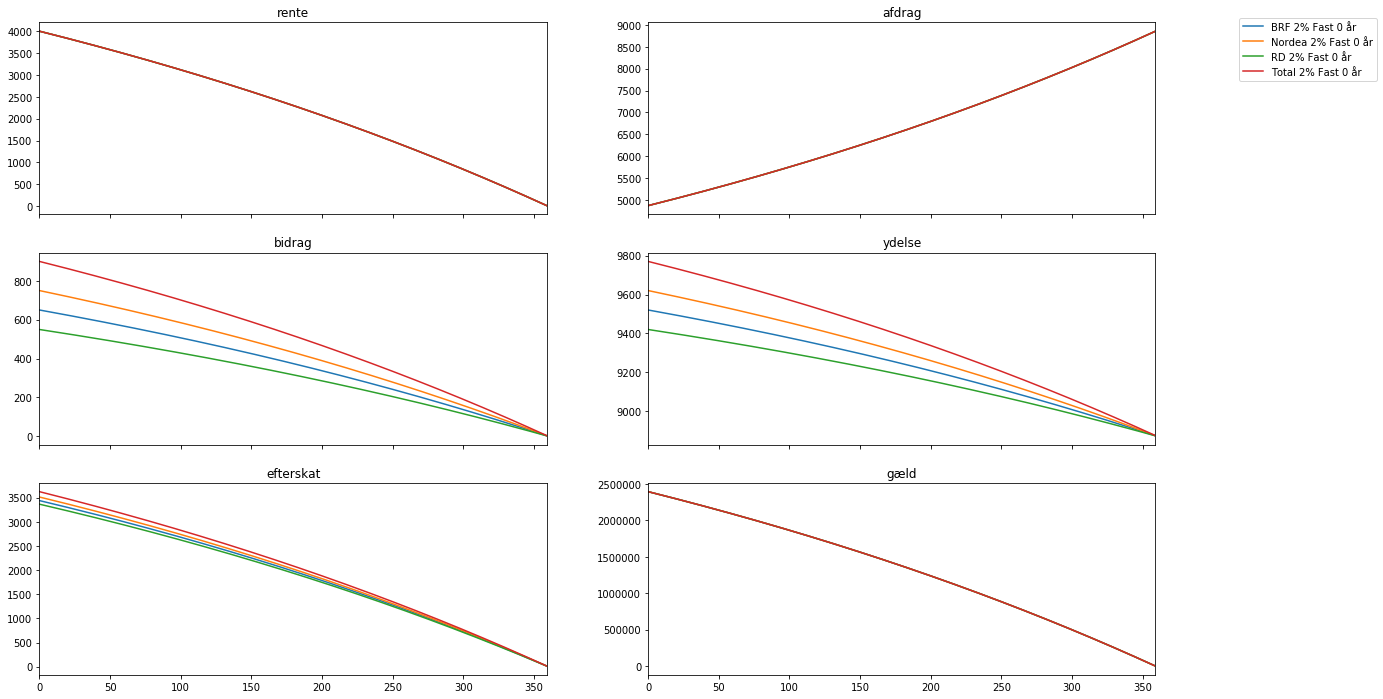

In [45]:
flere_lån = []
for bank in ('RD', 'BRF', 'Nordea', 'Total'):
    flere_lån.append(Lån(hovedstol, vurdering, løbetid, afdragsfrihed=0, rente=rente, skatteprocent=skatteprocent, bank=bank, låntype='Fast'))
sammenlign_plot(flere_lån)

Omkostninger efter skat: 
RD 2% Fast 0 år:	667880.21 kr
RD 2% Fast 5 år:	759445.62 kr
RD 2% Fast 10 år:	854291.68 kr



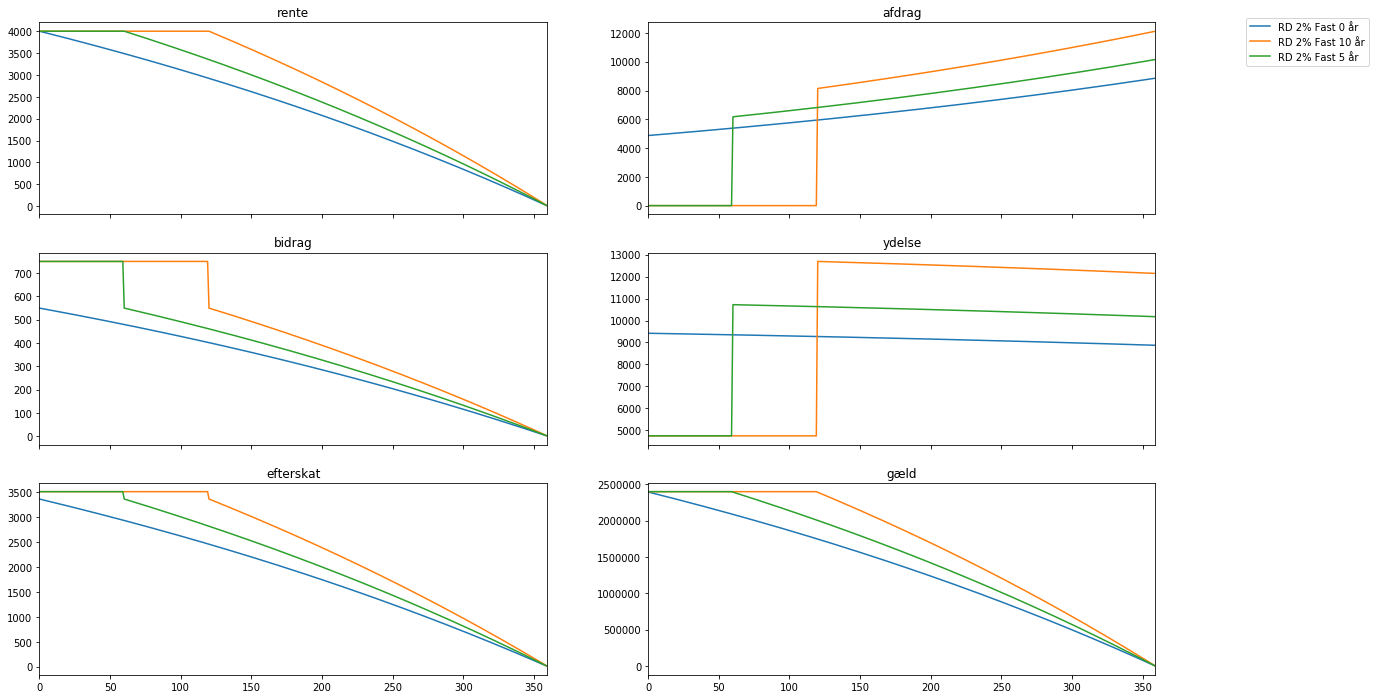

In [46]:
flere_lån = []
for afdrag in (0, 5, 10):
    flere_lån.append(Lån(hovedstol, vurdering, løbetid, afdragsfrihed=afdrag, rente=rente, skatteprocent=skatteprocent, bank='RD', låntype='Fast'))
sammenlign_plot(flere_lån);

In [66]:
afdragsfri_omkost_rente_bidrag = flere_lån[2].omkostninger()[1] - flere_lån[0].omkostninger()[1]
afdragsfri_omkost_kurs = (kurser['RD']['uafdrag'] - kurser['RD']['afdrag']) * hovedstol / 100
afdragsfri_omkost_total = afdragsfri_omkost_rente_bidrag + afdragsfri_omkost_kurs

print('Ekstra omkostning ved afdragsfrihed\n  Bidrag og renter:\t{:0.2f}\n  Kurs:\t\t\t{:0.2f}\n  Total:\t\t{:0.2f}\n'\
      .format(afdragsfri_omkost_rente_bidrag, afdragsfri_omkost_kurs, afdragsfri_omkost_total))

print('Ekstra omkostning ved afdragsfrihed pr. måned\n  Bidrag og renter:\t{:0.2f}\n  Kurs:\t\t\t{:0.2f}\n  Total:\t\t{:0.2f}'\
      .format(afdragsfri_omkost_rente_bidrag/30/12, afdragsfri_omkost_kurs/30/12, afdragsfri_omkost_total/30/12))

Ekstra omkostning ved afdragsfrihed
  Bidrag og renter:	186411.47
  Kurs:			34080.00
  Total:		220491.47

Ekstra omkostning ved afdragsfrihed pr. måned
  Bidrag og renter:	517.81
  Kurs:			94.67
  Total:		612.48


In [76]:
flere_lån[0].forløb.head()

,rente,afdrag,bidrag,ydelse,efterskat,gæld
0,4000.000000,4870.867345,549.600000,9420.467345,3366.704000,2.395129e+06
1,3991.881888,4878.985457,548.484571,9419.351916,3359.871180,2.390250e+06
2,3983.750245,4887.117099,547.367284,9418.234628,3353.026971,2.385363e+06
3,3975.605050,4895.262294,546.248134,9417.115478,3346.171356,2.380468e+06
4,3967.446280,4903.421065,545.127119,9415.994463,3339.304315,2.375564e+06


In [71]:
flere_lån[2].forløb.head()

,rente,afdrag,bidrag,ydelse,efterskat,gæld
0,4000.0,0.0,749.6,4749.6,3514.704,2400000.0
1,4000.0,0.0,749.6,4749.6,3514.704,2400000.0
2,4000.0,0.0,749.6,4749.6,3514.704,2400000.0
3,4000.0,0.0,749.6,4749.6,3514.704,2400000.0
4,4000.0,0.0,749.6,4749.6,3514.704,2400000.0
